In [1]:
#Import Dependencies
import pandas as pd

In [2]:
#List for use later when checking letter matches
letter_spacing = ["L1", "L2", "L3", "L4", "L5"]

In [3]:
#Function List for Wordle Solver

#Function to narrow down word list if letter is in the correct place
def letter_correct(letter, position, words_df):
    words_df = words_df.loc[words_df[position]==letter,:]
    return words_df

#Function to narrow down word list if letter is not in the word
def letter_missing(letter, words_df):
    for position in ["L1", "L2", "L3", "L4", "L5"]:
        words_df = words_df.loc[words_df[position]!=letter,:]
    return words_df
    
#Function to narrow down word list if letter is in the wrong place
def letter_misplaced(letter, position, words_df):
    words_df = words_df.loc[words_df[position]!=letter,:]
    space_list = ["L1", "L2", "L3", "L4", "L5"]
    space_list.remove(position)
    words_df = words_df.loc[(words_df[space_list[0]]==letter) | (words_df[space_list[1]]==letter) | (words_df[space_list[2]]==letter) | (words_df[space_list[3]]==letter),:]
    return words_df

In [4]:
#Function to 'play the game'
def next_guess(words_df):
    
    scoredict = {}
    for index, row in words_df.iterrows():
        for position in letter_spacing:
            if row[position] in scoredict:
                scoredict[row[position]]+=1
            else:
                scoredict[row[position]] = 1
    score_table = pd.Series(data=scoredict).to_frame().reset_index().rename(columns={'index':'letter',0:'totalcount'})
    
    #Score each word based on letter frequency to choose the best guess. We do this by merging each individual letter to the score
    #table, then adding them into a final score to append to our word table. If a letter is a duplicate, we do not add that score
    #since the information added is likely to be none or very little, and we would gain more for having better variety
    score_list = []
    for index, row in words_df.iterrows():
        score = 0
        letter1_score = [row["L1"], score_table.loc[score_table["letter"]==row["L1"],"totalcount"].values[0]]
        letter2_score = [row["L2"], score_table.loc[score_table["letter"]==row["L2"],"totalcount"].values[0]]
        letter3_score = [row["L3"], score_table.loc[score_table["letter"]==row["L3"],"totalcount"].values[0]]
        letter4_score = [row["L4"], score_table.loc[score_table["letter"]==row["L4"],"totalcount"].values[0]]
        letter5_score = [row["L5"], score_table.loc[score_table["letter"]==row["L5"],"totalcount"].values[0]]
        score = letter1_score[1]
        if letter2_score[0] != letter1_score[0]:
            score = score + letter2_score[1]
        if (letter3_score[0] != letter1_score[0] and letter3_score[0] != letter2_score[0]):
            score = score + letter3_score[1]
        if (letter4_score[0] != letter1_score[0] and letter4_score[0] != letter2_score[0] and letter4_score[0] != letter3_score[0]):
            score = score + letter4_score[1]
        if (letter5_score[0] != letter1_score[0] and letter5_score[0] != letter2_score[0] and letter5_score[0] != letter3_score[0] and letter5_score[0] != letter4_score[0]):
            score = score + letter5_score[1]
        score_list.append(score)
    
    #Add Previous calcuations to word list
    words_df['Frequency_Score']=score_list
    
    #Choose best guess and create a dataframe split by letter, similar to word list
    maxid = words_df.Frequency_Score.idxmax()
    bestguess = words_df.iloc[maxid,0]
    bestguess_df = pd.DataFrame({"word":bestguess}, index=[0])
    bestguess_df["L1"] = bestguess_df["word"].astype(str).str[0]
    bestguess_df["L2"] = bestguess_df["word"].astype(str).str[1]
    bestguess_df["L3"] = bestguess_df["word"].astype(str).str[2]
    bestguess_df["L4"] = bestguess_df["word"].astype(str).str[3]
    bestguess_df["L5"] = bestguess_df["word"].astype(str).str[4]
    for letter in letter_spacing:
        space_list = ["L1", "L2", "L3", "L4", "L5"]
        space_list.remove(letter)
        
        #Use function if letter is correct in right spot
        if bestguess_df[letter].values[0] == hidden_word_df[letter].values[0]:
            words_df = letter_correct(bestguess_df[letter].values[0], letter, words_df)
            
        #Use function if letter is correct in wrong spot, also need to account for multiple same letters in the word
        elif (bestguess_df[letter].values[0] == hidden_word_df[space_list[0]].values[0]) or \
            (bestguess_df[letter].values[0] == hidden_word_df[space_list[1]].values[0]) or \
            (bestguess_df[letter].values[0] == hidden_word_df[space_list[2]].values[0]) or \
            (bestguess_df[letter].values[0] == hidden_word_df[space_list[3]].values[0]):
            words_df = letter_misplaced(bestguess_df[letter].values[0], letter, words_df)

        #Use function if letter is not in word
        else:
            words_df = letter_missing(bestguess_df[letter].values[0], words_df)
    words_df = words_df.reset_index(drop=True)
    return words_df, bestguess_df

In [5]:
results={}
allowed_guesses_df = pd.read_table("wordle-allowed-guesses.txt", delimiter=" ", header=None)
possible_words_df = pd.read_table("wordle-answers-alphabetical.txt", delimiter=" ", header=None)
words_df_static = pd.concat([allowed_guesses_df, possible_words_df]).reset_index(drop = True)
words_df_static = words_df_static.rename(columns={0:"word"})

for word in possible_words_df[0].to_list():
    numofguesses=0
    words_df = words_df_static
    
    #Split word in dataframe to letter per column
    words_df["L1"] = words_df["word"].astype(str).str[0]
    words_df["L2"] = words_df["word"].astype(str).str[1]
    words_df["L3"] = words_df["word"].astype(str).str[2]
    words_df["L4"] = words_df["word"].astype(str).str[3]
    words_df["L5"] = words_df["word"].astype(str).str[4]
    hidden_word_df = pd.DataFrame({"word":word}, index=[0])
    hidden_word_df["L1"] = hidden_word_df["word"].astype(str).str[0]
    hidden_word_df["L2"] = hidden_word_df["word"].astype(str).str[1]
    hidden_word_df["L3"] = hidden_word_df["word"].astype(str).str[2]
    hidden_word_df["L4"] = hidden_word_df["word"].astype(str).str[3]
    hidden_word_df["L5"] = hidden_word_df["word"].astype(str).str[4]
    
    for i in range(0,6):
        words_df, bestguess_df = next_guess(words_df)
        numofguesses+=1
        if bestguess_df["word"].values[0] == word:
            break
        elif (numofguesses==6) and (bestguess_df["word"].values[0] != word):
            numofguesses="lose"
            
    results[word]=numofguesses
    
    print(f"The result of {word} was {numofguesses}")
    
results

The result of aback was 4
The result of abase was 4
The result of abate was 5
The result of abbey was 5
The result of abbot was 4
The result of abhor was 3
The result of abide was 5
The result of abled was 4
The result of abode was 3
The result of abort was 3
The result of about was 5
The result of above was 6
The result of abuse was 3
The result of abyss was 5
The result of acorn was 5
The result of acrid was 5
The result of actor was 3
The result of acute was 4
The result of adage was 4
The result of adapt was 4
The result of adept was 3
The result of admin was 3
The result of admit was 3
The result of adobe was 4
The result of adopt was 6
The result of adore was 4
The result of adorn was 3
The result of adult was 4
The result of affix was 4
The result of afire was 5
The result of afoot was 4
The result of afoul was 4
The result of after was 6
The result of again was 3
The result of agape was 6
The result of agate was 6
The result of agent was 5
The result of agile was 5
The result o

The result of buyer was 4
The result of bylaw was 4
The result of cabal was lose
The result of cabby was 5
The result of cabin was 5
The result of cable was lose
The result of cacao was 4
The result of cache was 5
The result of cacti was 4
The result of caddy was 4
The result of cadet was 4
The result of cagey was 5
The result of cairn was 4
The result of camel was 5
The result of cameo was 3
The result of canal was 6
The result of candy was 4
The result of canny was 5
The result of canoe was 3
The result of canon was 6
The result of caper was 6
The result of caput was 4
The result of carat was 5
The result of cargo was 4
The result of carol was 6
The result of carry was lose
The result of carve was 4
The result of caste was 5
The result of catch was lose
The result of cater was 6
The result of catty was 6
The result of caulk was 4
The result of cause was 5
The result of cavil was 4
The result of cease was lose
The result of cedar was 4
The result of cello was 5
The result of chafe was

The result of eagle was 4
The result of early was 4
The result of earth was 4
The result of easel was 4
The result of eaten was 4
The result of eater was lose
The result of ebony was 5
The result of eclat was 4
The result of edict was 3
The result of edify was 4
The result of eerie was 6
The result of egret was 5
The result of eight was 4
The result of eject was 5
The result of eking was 5
The result of elate was 3
The result of elbow was 4
The result of elder was 5
The result of elect was 4
The result of elegy was 4
The result of elfin was 3
The result of elide was 3
The result of elite was 4
The result of elope was 6
The result of elude was 4
The result of email was 3
The result of embed was 4
The result of ember was 5
The result of emcee was 5
The result of empty was 3
The result of enact was 3
The result of endow was 4
The result of enema was 4
The result of enemy was 4
The result of enjoy was 4
The result of ennui was 4
The result of ensue was 5
The result of enter was 4
The resul

The result of guilt was 4
The result of guise was 5
The result of gulch was 4
The result of gully was 5
The result of gumbo was 5
The result of gummy was 6
The result of guppy was 6
The result of gusto was 4
The result of gusty was 4
The result of gypsy was 4
The result of habit was 5
The result of hairy was lose
The result of halve was 5
The result of handy was lose
The result of happy was 6
The result of hardy was lose
The result of harem was 6
The result of harpy was 5
The result of harry was 6
The result of harsh was 4
The result of haste was 6
The result of hasty was 4
The result of hatch was lose
The result of hater was lose
The result of haunt was 5
The result of haute was 5
The result of haven was 5
The result of havoc was 4
The result of hazel was 6
The result of heady was 4
The result of heard was 5
The result of heart was 5
The result of heath was 6
The result of heave was 5
The result of heavy was 4
The result of hedge was 4
The result of hefty was 3
The result of heist was

The result of moist was lose
The result of molar was 5
The result of moldy was 6
The result of money was lose
The result of month was 4
The result of moody was 6
The result of moose was lose
The result of moral was 2
The result of moron was 5
The result of morph was 4
The result of mossy was 4
The result of motel was 6
The result of motif was 4
The result of motor was 4
The result of motto was 6
The result of moult was 4
The result of mound was lose
The result of mount was 6
The result of mourn was 5
The result of mouse was lose
The result of mouth was 5
The result of mover was 6
The result of movie was 6
The result of mower was 3
The result of mucky was 6
The result of mucus was 5
The result of muddy was lose
The result of mulch was 3
The result of mummy was lose
The result of munch was 6
The result of mural was 4
The result of murky was 4
The result of mushy was 6
The result of music was 3
The result of musky was 4
The result of musty was lose
The result of myrrh was 3
The result of 

The result of rebut was 4
The result of recap was 5
The result of recur was 4
The result of recut was 3
The result of reedy was 4
The result of refer was 5
The result of refit was 5
The result of regal was 5
The result of rehab was 5
The result of reign was 4
The result of relax was 5
The result of relay was 6
The result of relic was 4
The result of remit was 6
The result of renal was 5
The result of renew was 6
The result of repay was 4
The result of repel was 5
The result of reply was 5
The result of rerun was 6
The result of reset was 3
The result of resin was 4
The result of retch was 4
The result of retro was 6
The result of retry was 6
The result of reuse was 3
The result of revel was 6
The result of revue was 5
The result of rhino was 3
The result of rhyme was 3
The result of rider was lose
The result of ridge was 4
The result of rifle was 3
The result of right was 4
The result of rigid was 4
The result of rigor was 4
The result of rinse was 3
The result of ripen was 5
The resul

The result of spine was 5
The result of spiny was 5
The result of spire was 6
The result of spite was 4
The result of splat was 4
The result of split was 3
The result of spoil was 5
The result of spoke was 4
The result of spoof was 6
The result of spook was lose
The result of spool was 4
The result of spoon was 3
The result of spore was lose
The result of sport was 5
The result of spout was lose
The result of spray was 3
The result of spree was 3
The result of sprig was 4
The result of spunk was 4
The result of spurn was 4
The result of spurt was 3
The result of squad was lose
The result of squat was 4
The result of squib was 5
The result of stack was 4
The result of staff was 5
The result of stage was 6
The result of staid was 6
The result of stain was 5
The result of stair was 3
The result of stake was 4
The result of stale was 4
The result of stalk was 3
The result of stall was 4
The result of stamp was lose
The result of stand was 4
The result of stank was 5
The result of stare was

The result of valor was 5
The result of value was 4
The result of valve was 5
The result of vapid was 5
The result of vapor was 4
The result of vault was lose
The result of vaunt was lose
The result of vegan was 5
The result of venom was 4
The result of venue was 5
The result of verge was 4
The result of verse was 3
The result of verso was 3
The result of verve was 5
The result of vicar was 5
The result of video was 3
The result of vigil was 5
The result of vigor was 3
The result of villa was 6
The result of vinyl was 4
The result of viola was 4
The result of viper was 5
The result of viral was 4
The result of virus was 3
The result of visit was 3
The result of visor was 3
The result of vista was 4
The result of vital was 5
The result of vivid was 5
The result of vixen was 5
The result of vocal was 5
The result of vodka was 5
The result of vogue was 6
The result of voice was 4
The result of voila was 5
The result of vomit was 4
The result of voter was 4
The result of vouch was lose
The

{'aback': 4,
 'abase': 4,
 'abate': 5,
 'abbey': 5,
 'abbot': 4,
 'abhor': 3,
 'abide': 5,
 'abled': 4,
 'abode': 3,
 'abort': 3,
 'about': 5,
 'above': 6,
 'abuse': 3,
 'abyss': 5,
 'acorn': 5,
 'acrid': 5,
 'actor': 3,
 'acute': 4,
 'adage': 4,
 'adapt': 4,
 'adept': 3,
 'admin': 3,
 'admit': 3,
 'adobe': 4,
 'adopt': 6,
 'adore': 4,
 'adorn': 3,
 'adult': 4,
 'affix': 4,
 'afire': 5,
 'afoot': 4,
 'afoul': 4,
 'after': 6,
 'again': 3,
 'agape': 6,
 'agate': 6,
 'agent': 5,
 'agile': 5,
 'aging': 'lose',
 'aglow': 3,
 'agony': 5,
 'agora': 6,
 'agree': 4,
 'ahead': 4,
 'aider': 3,
 'aisle': 4,
 'alarm': 4,
 'album': 4,
 'alert': 4,
 'algae': 6,
 'alibi': 4,
 'alien': 3,
 'align': 3,
 'alike': 4,
 'alive': 5,
 'allay': 5,
 'alley': 4,
 'allot': 6,
 'allow': 5,
 'alloy': 'lose',
 'aloft': 3,
 'alone': 4,
 'along': 3,
 'aloof': 4,
 'aloud': 4,
 'alpha': 5,
 'altar': 5,
 'alter': 3,
 'amass': 'lose',
 'amaze': 4,
 'amber': 5,
 'amble': 5,
 'amend': 3,
 'amiss': 5,
 'amity': 4,
 'among': 

In [8]:
result_df = pd.Series(data=results).to_frame().reset_index().rename(columns={'index':'word',0:'result'})
result_df

,word,result
0,aback,4
1,abase,4
2,abate,5
3,abbey,5
4,abbot,4
...,...,...
2310,young,4
2311,youth,3
2312,zebra,6
2313,zesty,5


In [11]:
results_grouped = result_df.groupby(by="result").count()
results_grouped

,word
result,
2,16
3,278
4,809
5,643
6,315
lose,254


<AxesSubplot:xlabel='result'>

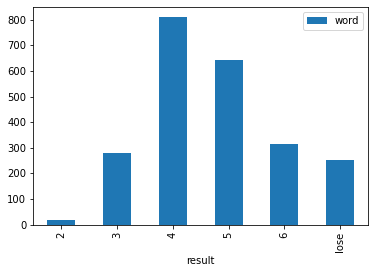

In [12]:
results_grouped.plot(kind="bar")

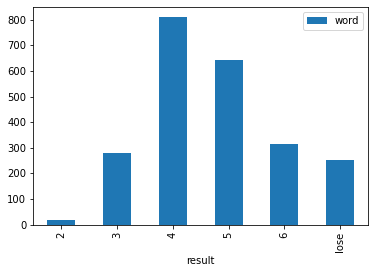

In [13]:
plot = results_grouped.plot(kind='bar')
fig = plot.get_figure()
fig.savefig("output.png")